<a href="https://colab.research.google.com/github/vishwanath103/MIT-DL-Course/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 7.1MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115442 sha256=6832c78323d42d2eb6edd237b4ba9ff5d2b35d8b002c97f9c72cf71c66dc4d03
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


# Part 1: Cartpole

## Define the Cartpole environment and agent

### Environment

In [2]:
env = gym.make("CartPole-v0")
env.seed(1)

[1]

Our observations in this Cartpole environment are:
1. Cart position
2. Cart Velocity
3. Pole angle
4. Pole rotation rate

In [3]:
n_observations = env.observation_space
print("Environment has observation space = ", n_observations)

Environment has observation space =  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [4]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### Cartpole agent

In [5]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
  model = tf.keras.models.Sequential([
        # First Dense layer
        tf.keras.layers.Dense(units=32, activation='relu'),
        # Define the last Dense layer, which will provide the network's output
        tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

cartpole_model = create_cartpole_model()

In [6]:
### Define the agents action function ###

# Fucntion that takes observations as input, executes a forward pass through model,
#   and outputs a sampled action
# Arguments:
#   model: the network that defines our agent
#   observation: observation(s) which is/are fed as input to the model
#   single: flag as to whether we are handling a single observation or batch of
#     observation, provided as an np.array
# Returns:
#   action: choice of agent action
def choose_action(model, observation, single=True):
  # add batch dimension to the observation if only a single example was provided
  observation = np.expand_dims(observation, axis=0) if single else observation

  # Feed the observations through the model to predict the log probabilities of each posible action
  logits = model.predict(observation)

  # Choose an action
  action = tf.random.categorical(logits, num_samples=1)
  action = action.numpy().flatten()
  return action[0] if single else action

## Define the agents memory

In [12]:
### Agent Memory ###

class Memory:
  def __init__(self):
    self.clear()

  # Resets/restarts the memory buffer
  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_action)
    self.rewards.append(new_reward)

# Helper function to combine a list of Memory objects into a single Memory.
def aggregate_memories(memories):
  batch_memory = Memory()

  for memory in memories:
    for step in zip(memory.observations, memory.actions, memory.rewards):
      batch_memory.add_to_memory(*step)

  return batch_memory

# Instantiate a single Memory buffer
memory = Memory()

## Reward Function

In [8]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
    # update the total discounted reward
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R

  return normalize(discounted_rewards)

## Learning Algorithm

In [9]:
### Loss Function ###

# Arguments:
#   logits: networks predictions for actions to take
#   actions: the action agent took in an episode
#   rewards: the reward the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards):
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  loss = tf.reduce_mean(neg_logprob*rewards)
  return loss

In [14]:
### Tarining step(forward and backpropagation) ###
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
    # Forward propagate through the agent network
    logits = model(observations)
    loss = compute_loss(logits, actions, discounted_rewards)
  
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Run Cartpole

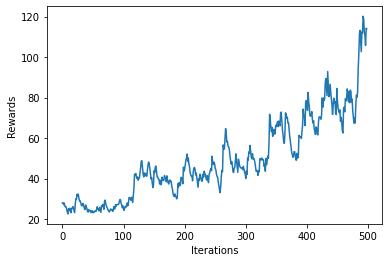

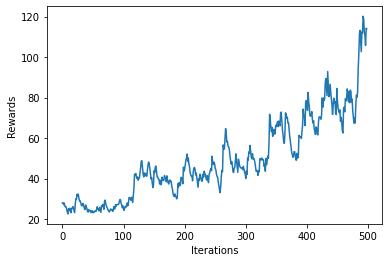

In [15]:
## Cartpole training ##

# Learning rate and optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()
for i_episode in range(500):
  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation = env.reset()
  memory.clear()

  while True:
    # using our observation, choose an action and take it in environment
    action = choose_action(cartpole_model, observation)
    next_observation, reward, done, info = env.step(action)
    # add to memory
    memory.add_to_memory(observation, action, reward)

    # is the episode over? did you crash or do so well that you are done?
    if done:
      # determine total reward and keep a record of this
      total_reward = sum(memory.rewards)
      smoothed_reward.append(total_reward)

      # intiate training
      train_step(cartpole_model, optimizer,
                 observations=np.vstack(memory.observations),
                 actions=np.array(memory.actions),
                 discounted_rewards=discount_rewards(memory.rewards))
      memory.clear()
      break

    observation = next_observation

In [16]:
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 200 frames into CartPole-v0.mp4!


# Pong

## Define and inspect the pong environment

In [17]:
def create_pong_env():
  return gym.make("Pong-v0", frameskip=5)
env = create_pong_env()
env.seed(1)

[1, 289714752]

In [18]:
print("Environment has observation space =", env.observation_space)

Environment has observation space = Box(0, 255, (210, 160, 3), uint8)


In [19]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 6


## Define the Pong agent

In [20]:
### Define the Pong agent ###

# Functionally define layers for convenience
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Define a CNN for the Pong agent
def create_pong_model():
  model = tf.keras.models.Sequential([
        # First, 32 5*5 filters and 2*2 stride
        Conv2D(filters=32, kernel_size=5, strides=2),
        Conv2D(filters=48, kernel_size=5, strides=2),
        Conv2D(filters=64, kernel_size=3, strides=2),
        Conv2D(filters=64, kernel_size=3, strides=2),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=n_actions, activation=None)
  ])
  return model

pong_model = create_pong_model()

In [21]:
### Pong reward function ###

def discount_rewards(rewards, gamma=0.99):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
    # reset the sum if the reward is not 0 ( the game has ended)
    if rewards[t] != 0:
      R = 0
    R = R*gamma + rewards[t]
    discount_rewards[t] = R

  return normalize(discounted_rewards)

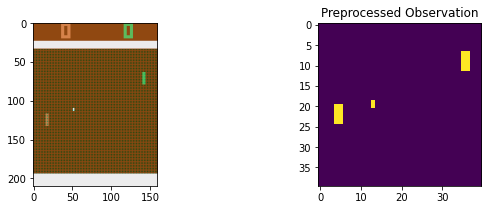

In [22]:
observation = env.reset()
for i in range(30):
  action = np.random.choice(n_actions)
  observation, _, _, _ = env.step(action)
observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid(False);
ax2.imshow(np.squeeze(observation_pp)); ax2.grid(False); plt.title('Preprocessed Observation');

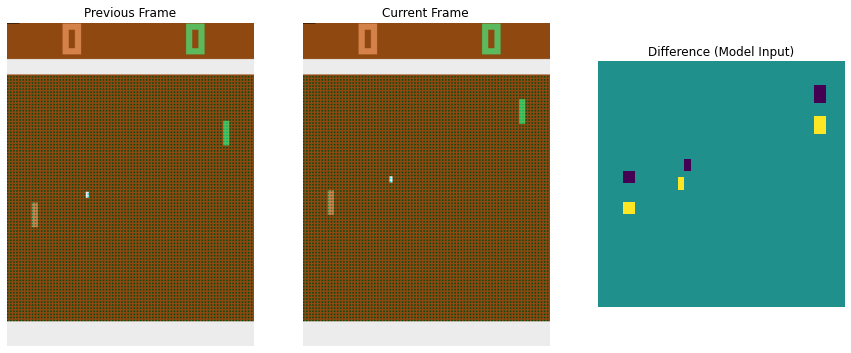

In [23]:
next_observation, _,_,_ = env.step(np.random.choice(n_actions))
diff = mdl.lab3.pong_change(observation, next_observation)

f, ax = plt.subplots(1, 3, figsize=(15,15))
for a in ax:
  a.grid(False)
  a.axis("off")
ax[0].imshow(observation); ax[0].set_title('Previous Frame');
ax[1].imshow(next_observation); ax[1].set_title('Current Frame');
ax[2].imshow(np.squeeze(diff)); ax[2].set_title('Difference (Model Input)');